# <b>Classification of Covid Infection Based on Chest X-Ray Images</b>
### <b>Table of Contents</b> <a id="table_contents"></a>
This is the milestone 5 of the CS109B class during Spring 2024 with members Xinyu Chen, Adele Collin, Chuck Lin, Kay Wu (Group #22). 

*Note that the internal links of the table of contents work in Jupyter notebook, but VSCode and Google Colab may have compatibility issues.*

1. [Motivation and Problem Statement](#problem_statement)
2. [Data Preprocessing and EDA](#data)
3. [Modeling Approach and Process](#modeling)
4. [Results and Discussion](#results_discussion)

### Description of Python Libraries
_General python packages such as pandas, matplotlib, numpy, pathlib, random, and seaborn were used for data processing. The skimage library was used for image preprocessing. All modeling was done with the tensorflow package, including but not limited to the layers modules, optimizers, callbacks, and the transfer learning models fom the application module. The sklearn module was used for splitting the training and testing sets as well as evaluation metrics for model performance._

In [14]:
################################################################################
# IMPORT LIBRARIES
################################################################################
import os
import time
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import random
import skimage
from skimage.transform import resize
from pathlib import Path
from scipy.ndimage import gaussian_filter

import tensorflow as tf
from tensorflow.keras.layers import Input, GaussianNoise, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, schedules
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

<a id="problem_statement"></a>
# 1. Motivation and Problem Statement

[Return to table of contents](#table_contents)

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

The Covid-19 pandemic from 2019 to 2023 caused massive health burdens and death, public health and government expenditures, and severe market loss and societal fluctuations. In fact, within 2024 where Covid-19 has officially been announced to end, according to CDC there were still 7 million hospitalizations due to Covid to date ([accessed April 2024 from CDC](https://covid.cdc.gov/covid-data-tracker/#datatracker-home)). Within the health system, the vast number of population impacted by the virus overloaded the hospistals. The challenges presented by Covid include but are not limited to the shortage in medical supplies and resource allocation depending on condition severity and overwhelmed medical staff. Overall the resources were limited for the patients impacted and often caused delay in treatment with consequences that could have been avoided. A machine learning model that is able to preliminarily screen chest x-rays for patients for identification of Covid infections would be beneficial for addressing the problem (eg. for early detection, treatment, supportive care, and implementation of public health policies), and here we propose to test the performance of such a model. 

Through the development and validation of the model, we ask the following question: can signs of Covid-19 in x-ray scans be identified using machine learning approaches, to predict whether a patient has covid or not, with noisy image sets (e.g. patients have none or a variety of concurrent conditions other than covid, image rotation, position of patient taking the x ray, e.t.c.)? And how robust will this prediction be to different clinical settings? 

<a id="data"></a>
# 2. Data Preprocessing and EDA

[Return to table of contents](#table_contents)

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

<b>Summary of datasets</b>

In order to address the question asked in the problem statement, we utilized three different datasets as the positive training set, the negative training set, and the validation set. 

The first dataset is the positively labelled training set, the Brixia Score Covid19 Dataset, curated by ASST Spedali Civili di Brescia, comprises 4,707 chest X-ray (CXR) images obtained from sub-intensive and intensive care units over a specific period from March 4th to April 4th, 2020, notably coinciding with the peak of the COVID-19 pandemic. Brixia was acquired through both computed radiography (CR) and digital radiography (DX) modalities, encompassing both anterior-posterior (AP) and posterior-anterior (PA) projections.

The second dataset is the negatively labelled training set, the NIH Chest X-ray Dataset, consists of 112,120 frontal-view X-ray images extracted from 30,805 individual patients, and annotated with fourteen distinct thoracic pathologies derived from radiological reports. This dataset contained covid negative samples but also indicated other concurrent conditions, which this information were not contained in the other two datasets.

Lastly, the COVIDGR-1.0 dataset is the validation set containing both positive and negative samples, developed through collaboration with specialists from Hospital Universitario San Cecilio, Spain, comprises of 852 anonymized CXR images categorized into positive and negative instances based on the results of COVID-19 tests conducted via reverse transcription-polymerase chain reaction (RT-PCR) within 24 hours of image acquisition. Consistently captured in the posterior-anterior aspect, these images are classified according to severity levels and accompanied by demographic attributes, including gender distributions, for each identifiable class.


<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

<b> EDA and Preprocessing</b>

After several iterations of data exploration, compression, and preprocessing to handle the noisy heterogenousity of the massive datasets (summing up to over 100GB of data), the final preprocessing pipeline was determined based on EDA and preprocessing of earlier milestones. Based on the EDA from Milestone 3 and the TF feedback, we concluded that there were different distributions of the three datasets that we are using for training and testing our model. Furthermore, our original preprocessing approach resulted in some additional image padding and distortion because not all images were square. Thus, further preprocessing of the image data was necessary. 

We conducted a review of some of the literature on approaches used in chest x-ray classification for addressing distribution shifts. Broadly, common modelling approaches involve pre-training the model on a large, diverse image dataset and fine-tuning on data specific to a particular distribution, with the pre-training making the model robust to distribution shift (1). Studies that designed chest x-ray classifier models aimed at being generalizable have employed pixel value normalization to values between 0 and 1 (2) and resizing to 224 x 224 pixels (3). Other approaches include histogram equalization to extend the pixel’s intensity range from the original range to 0 to 255 such that the enhanced image has a wider range of intensity and slightly higher contrast, and adding Gaussian blur for noise reduction, which have been found to improve model performance (4). Still other approaches have used segmentation models such as U-net to segment and crop the lungs and convolutional neural networks for bone suppression for feature extraction and to enhance model performance despite distribution shifts (5).

Based on these insights and earlier EDA findings, we employed new image preprocessing approaches. Specifically, after retrieving the images from the original repositories, the images were first converted to png format to reduce size and preserve image quality, and then pre-compressed to size of 224 x 224 pixels and convered to numpy array on external GPU to facilitate numerical operations and compatibility with machine learning algorithms, which compressed the data from more than 100GB to around 3GB and allowed for data transmission and modeling. Next, to address the outliers that contribute to distorted images after resizing, we filtered out the samples with low image intensity (to define these terms, pixel intensity refers to the brightness or grayscale value of an individual pixel in a digital image. Image intensity, on the other hand, refers to the overall brightness or grayscale value of an entire image. It represents the collective pixel intensities across all pixels in the image). However, there were more variations across the datasets that weren't fully addressed by image intensity, for example the graphical labelling such as the letters indicating position of the patient when the x-ray was taken, varies in the datasets. Therefore, we employed additional preprocessing techniques. We normalized the image intensity to a range of (0, 1) to reduce brightness level variation across different images, and performed histogram equalization to enhance image contrast and make image contrast across datasets more consistent. Finally, we also added Gaussian blur for denoising purposes, smoothing out the pixel intensity variations in the image. In summary, the feature engineering process aims to standardize and enhance the quality of chest x-ray images for subsequent analysis.

As shown in the new EDA with the image pixel and image intensity, as well as sampled images from the preprocessed data below, we can see that while not all issues with the padding have resolved (e.g. some images were pre-rotated to address patient rotation but this resulted in padding at the corners), we were able to resolve the issues with distribution shift and image distortion such that these are approximately similar/consistent across the different datasets. It is worth noting that only EDA relevant to the final datasets are included here, factors such as demographics weren't included in the validation dataset and ultimately did not get incorporated into modeling for that reason, and are thus not demonstrated in this report, but can be referred to in reports from earlier milestones. The transfer learning modeling used for the final modeling should also indirectly improve the performance of models on nonhomogenous datasets.

**References**
1. https://arxiv.org/pdf/2403.00194.pdf
2. https://www.nature.com/articles/s41598-024-56171-6
3. https://pubs.rsna.org/doi/epdf/10.1148/radiol.2020203511
4. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949
5. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9818166/ 

In [22]:
################################################################################
# Data Exploration BEFORE PREPROCESSING
################################################################################
# NIHCXR 
df_nihcxr = np.load("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/NIHCXR.npy", allow_pickle = True)
df_nihcxr_dict = df_nihcxr.item()

# Create a new dictionary to store the truncated keys and values
truncated_df_nihcxr_dict = {}

# Iterate over keys and values
for key, value in df_nihcxr_dict.items():
    # Convert PosixPath object to string and truncate the key
    truncated_key = Path(key).name
    # Update the new dictionary with truncated key and corresponding value
    truncated_df_nihcxr_dict[truncated_key] = value

# Load the CSV file containing filenames and their corresponding labels
nihcxr_labels = pd.read_csv("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/NIHCXR/Data_Entry_2017_v2020.csv")  

# Filter the filenames with the label "No Finding"
no_finding_filenames = nihcxr_labels[nihcxr_labels["Finding Labels"] == "No Finding"]["Image Index"].tolist()

# Filter the truncated dict to only include filenames with the label "No Finding"
filtered_df_nihcxr_dict = {filename: image_array for filename, image_array in truncated_df_nihcxr_dict.items() if filename in no_finding_filenames}

#filtered_df_nihcxr_dict.keys()

In [24]:
# BRIXIA
df_brixia = np.load("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/Brixia.npy", allow_pickle = True)
df_brixia_dict = df_brixia.item()

# Create a new dictionary to store the truncated keys and values
truncated_df_brixia_dict = {}

# Iterate over keys and values
for key, value in df_brixia_dict.items():
    # Convert PosixPath object to string and truncate the key
    truncated_key = Path(key).name
    # Update the new dictionary with truncated key and corresponding value
    truncated_df_brixia_dict[truncated_key] = value

In [25]:
# COVIDGR POSITIVE
df_covidgr_p = np.load("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/COVIDGR_1.0_P.npy", allow_pickle = True)
df_covidgr_p_dict = df_covidgr_p.item()

# Create a new dictionary to store the truncated keys and values
truncated_df_covidgr_p_dict = {}

# Iterate over keys and values
for key, value in df_covidgr_p_dict.items():
    # Convert PosixPath object to string and truncate the key
    truncated_key = Path(key).name
    # Update the new dictionary with truncated key and corresponding value
    truncated_df_covidgr_p_dict[truncated_key] = value

In [26]:
# COVIDGR NEGATIVE
df_covidgr_n = np.load("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/COVIDGR_1.0_N.npy", allow_pickle = True)
df_covidgr_n_dict = df_covidgr_n.item()

# Create a new dictionary to store the truncated keys and values
truncated_df_covidgr_n_dict = {}

# Iterate over keys and values
for key, value in df_covidgr_n_dict.items():
    # Convert PosixPath object to string and truncate the key
    truncated_key = Path(key).name
    # Update the new dictionary with truncated key and corresponding value
    truncated_df_covidgr_n_dict[truncated_key] = value

In [27]:
# Convert the dictionary values to lists of numpy arrays
nihcxr_arrays = list(filtered_df_nihcxr_dict.values())
brixia_arrays = list(truncated_df_brixia_dict.values())
covidgr_n_arrays = list(truncated_df_covidgr_n_dict.values())
covidgr_p_arrays = list(truncated_df_covidgr_p_dict.values())

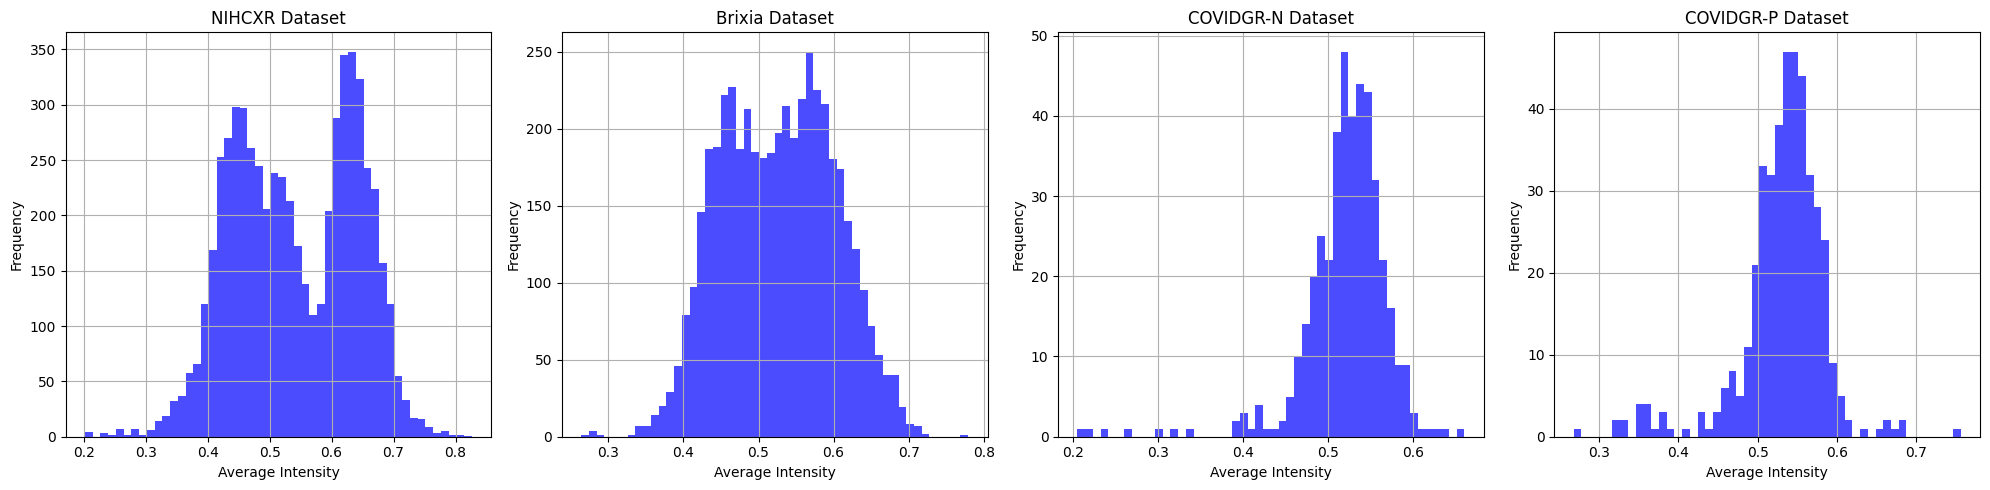

In [28]:
def plot_average_intensity(image_arrays, title, ax):
    # Calculate average intensity for each image
    average_intensities = [np.mean(image) for image in image_arrays]

    # Plot histogram of average intensities
    ax.hist(average_intensities, bins=50, color='blue', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Average Intensity')
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Create a figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot average intensity for each dataset
plot_average_intensity(nihcxr_arrays, 'NIHCXR Dataset', axes[0])
plot_average_intensity(brixia_arrays, 'Brixia Dataset', axes[1])
plot_average_intensity(covidgr_n_arrays, 'COVIDGR-N Dataset', axes[2])
plot_average_intensity(covidgr_p_arrays, 'COVIDGR-P Dataset', axes[3])

# Adjust layout
plt.tight_layout()
plt.show()

<b>`Figure 1`.</b> Average intensity for images, for all three datasets, before preprocessing.

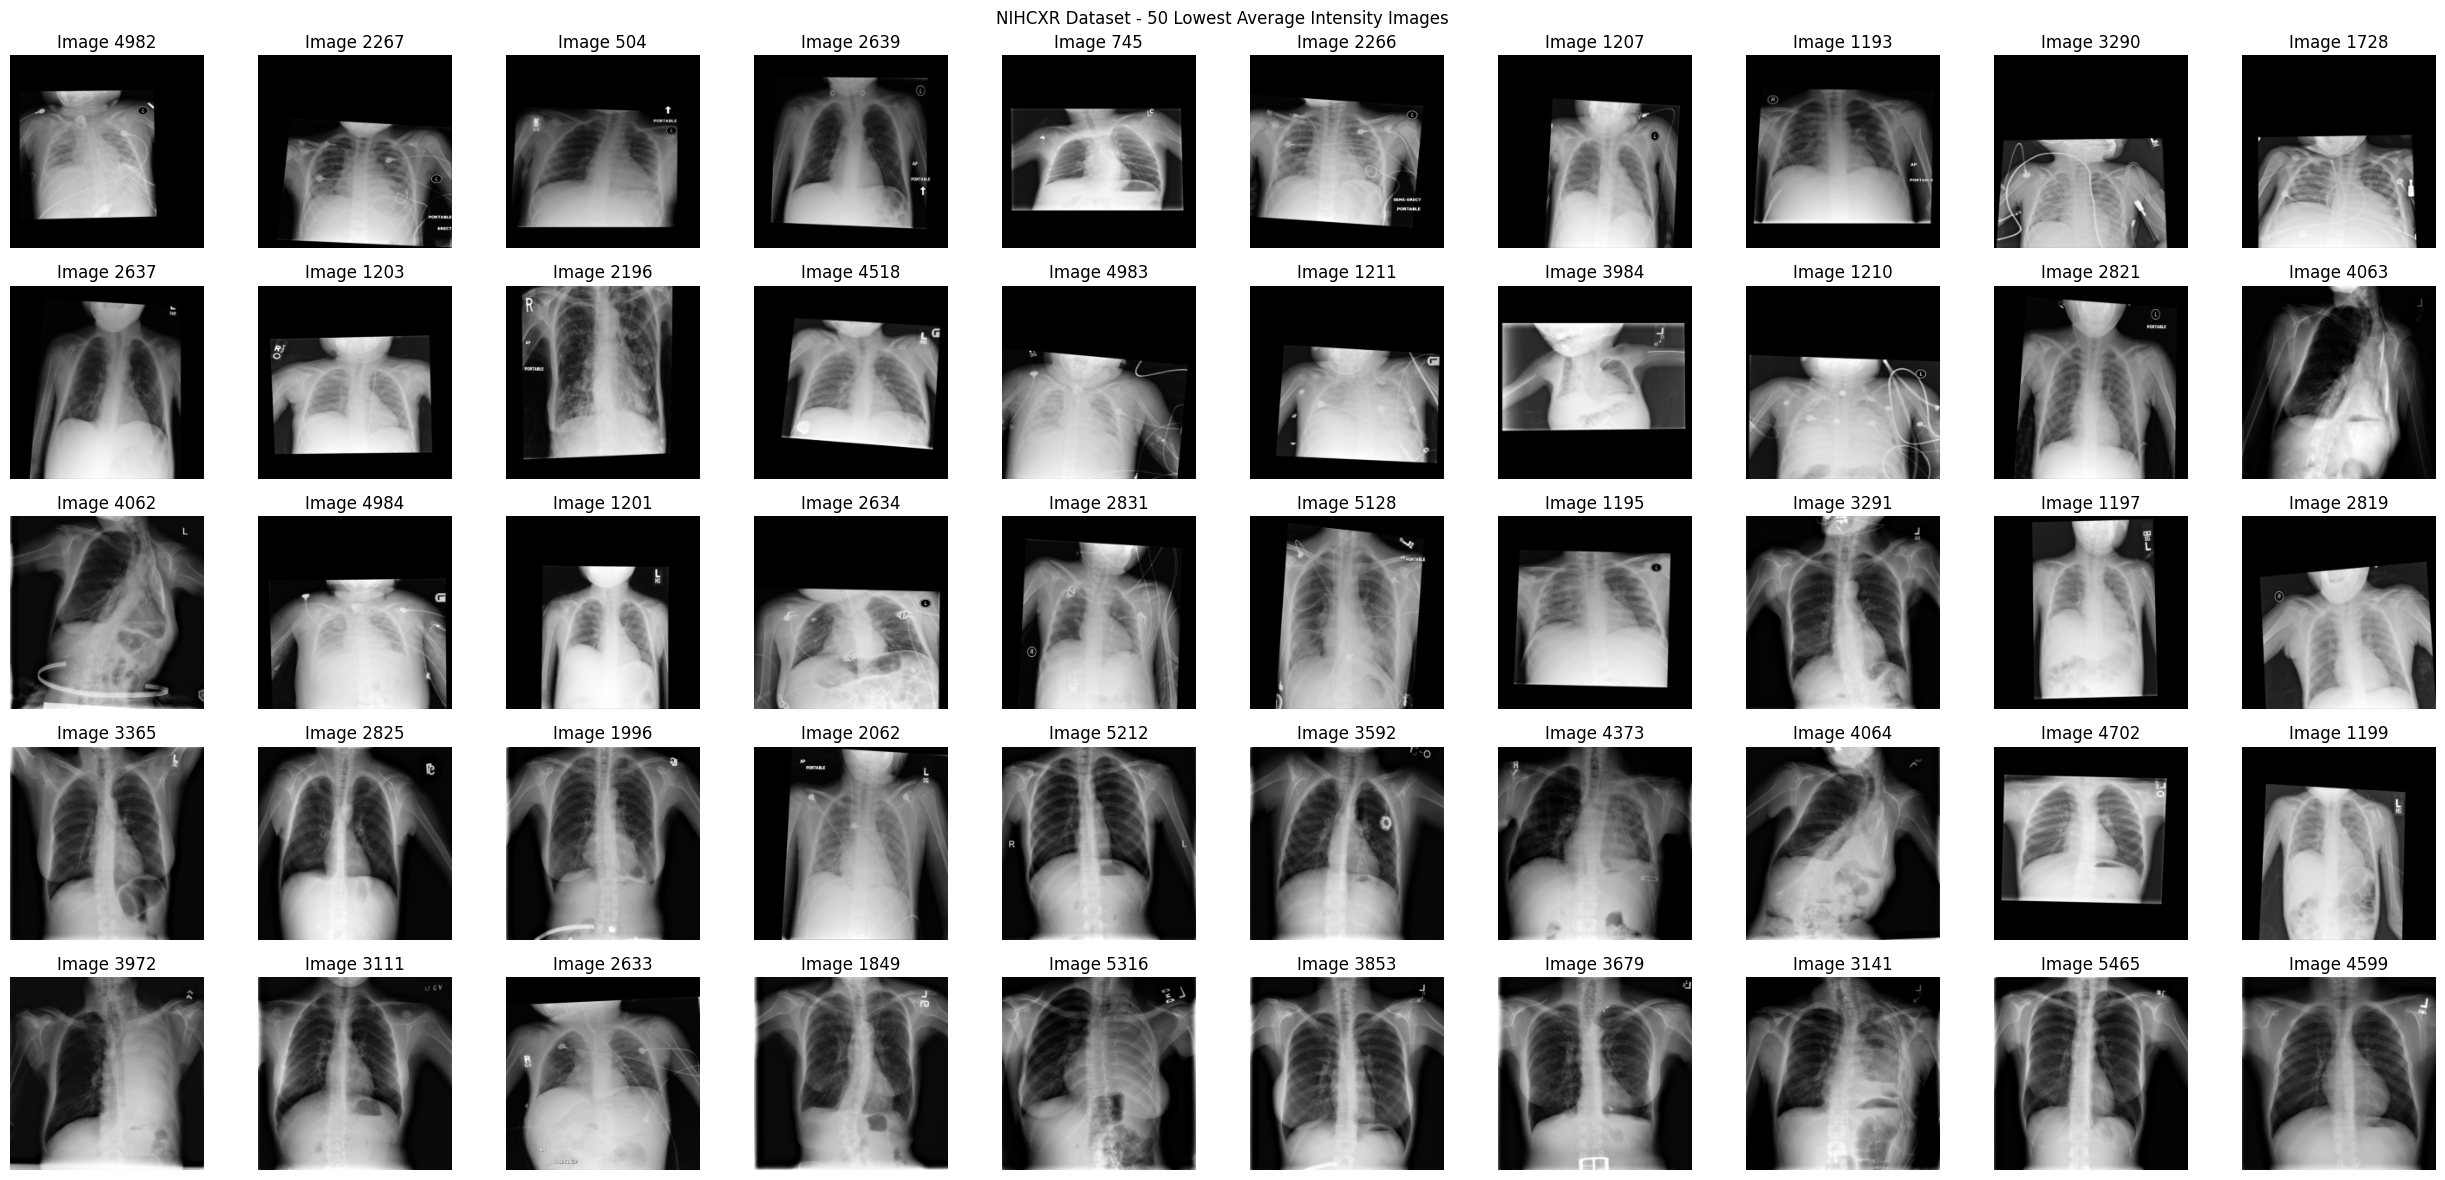

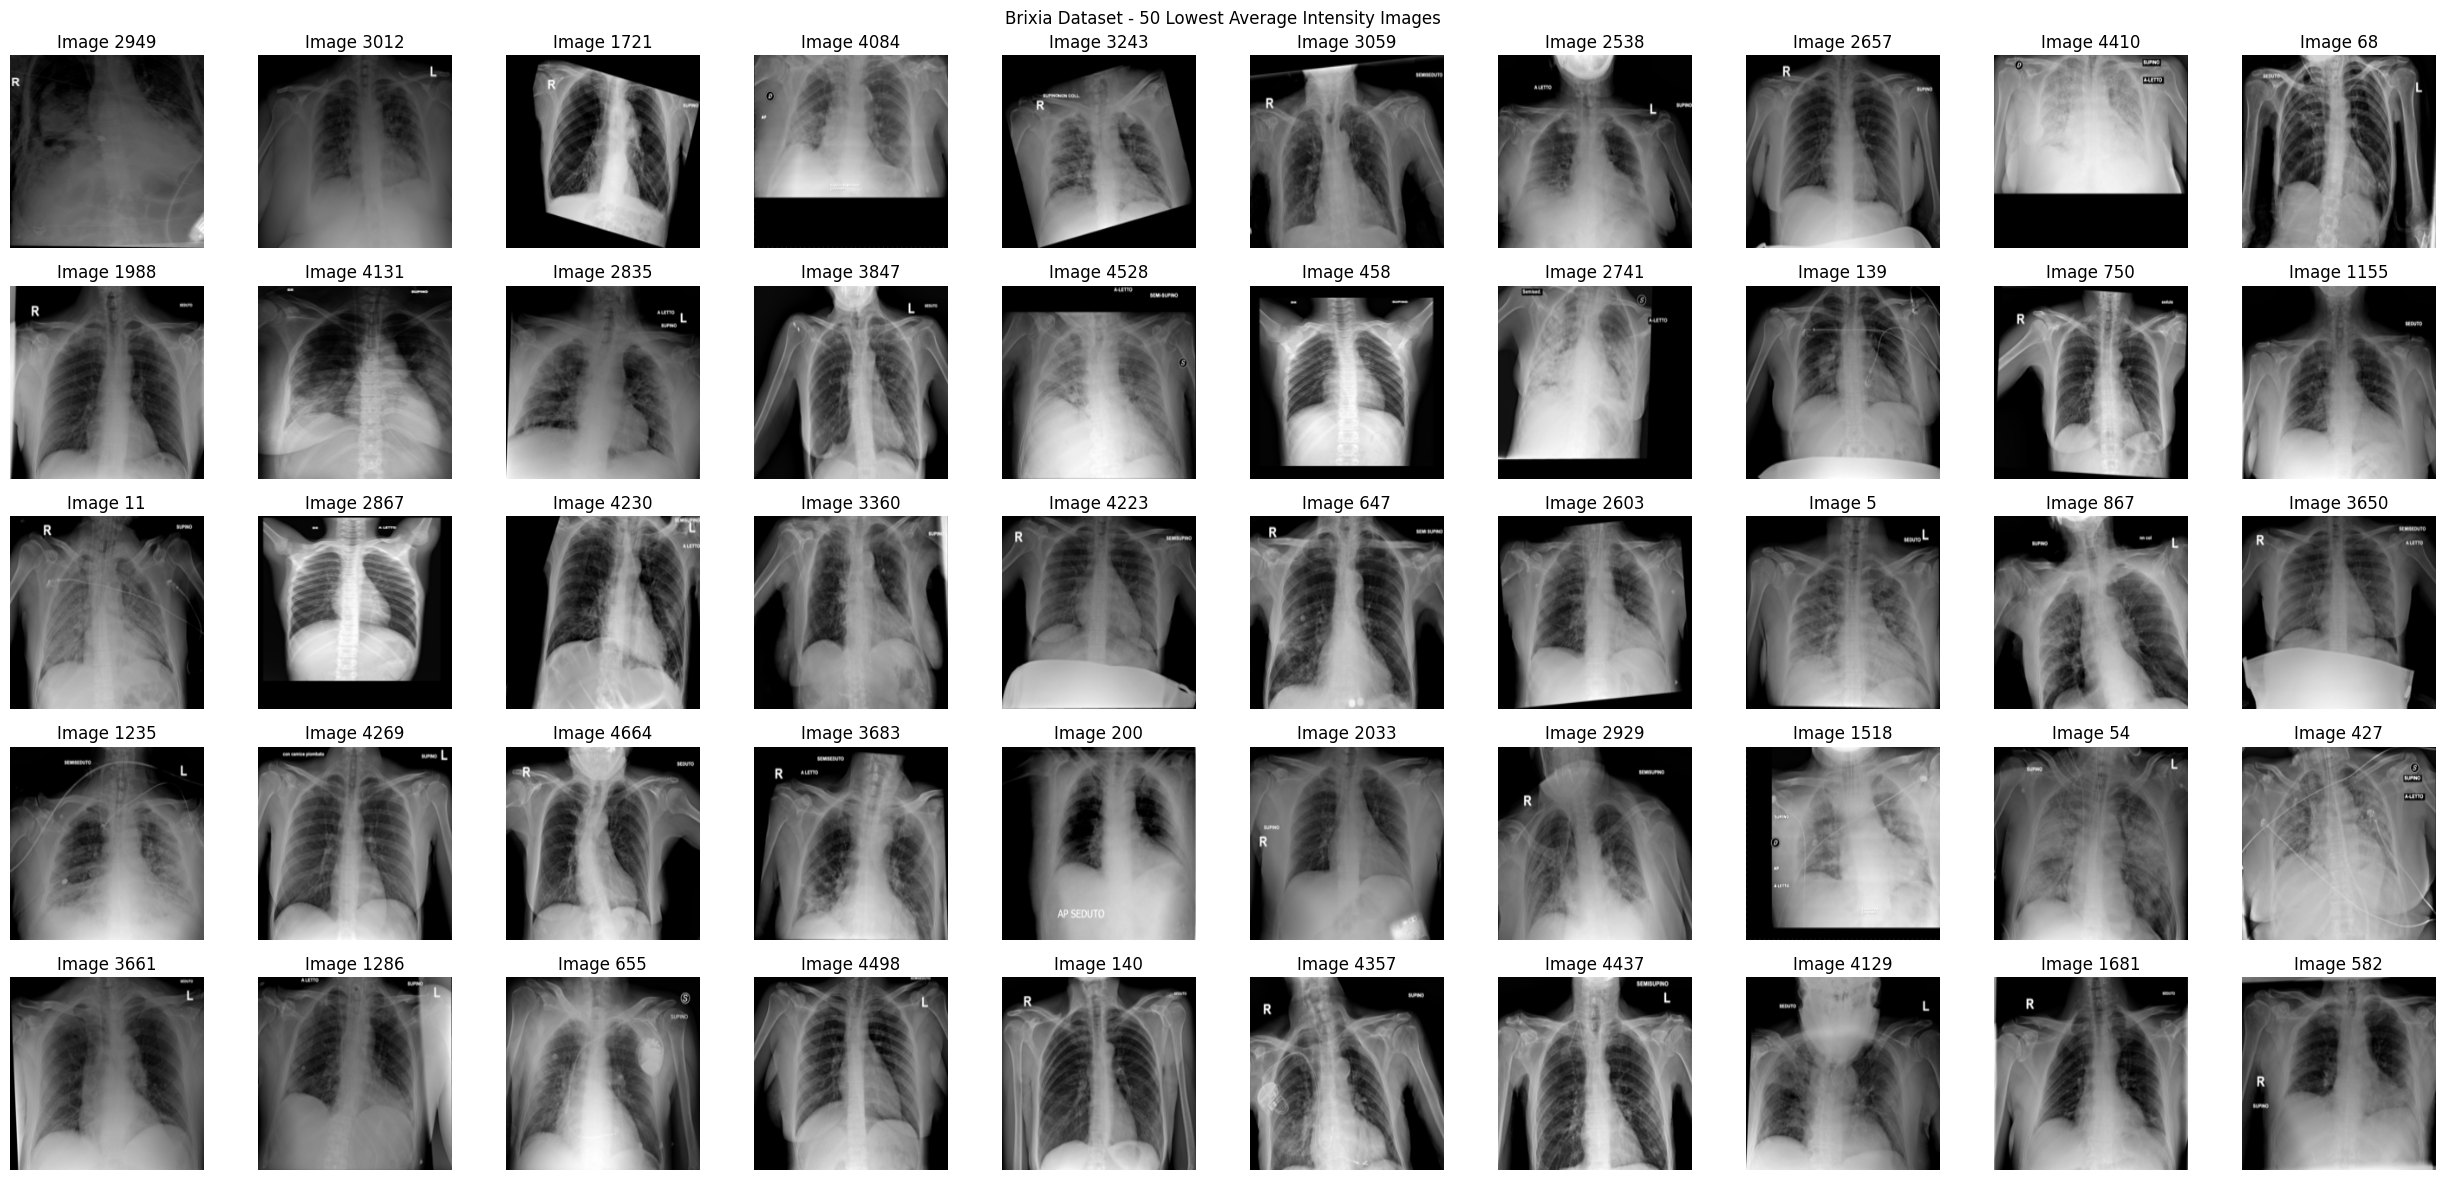

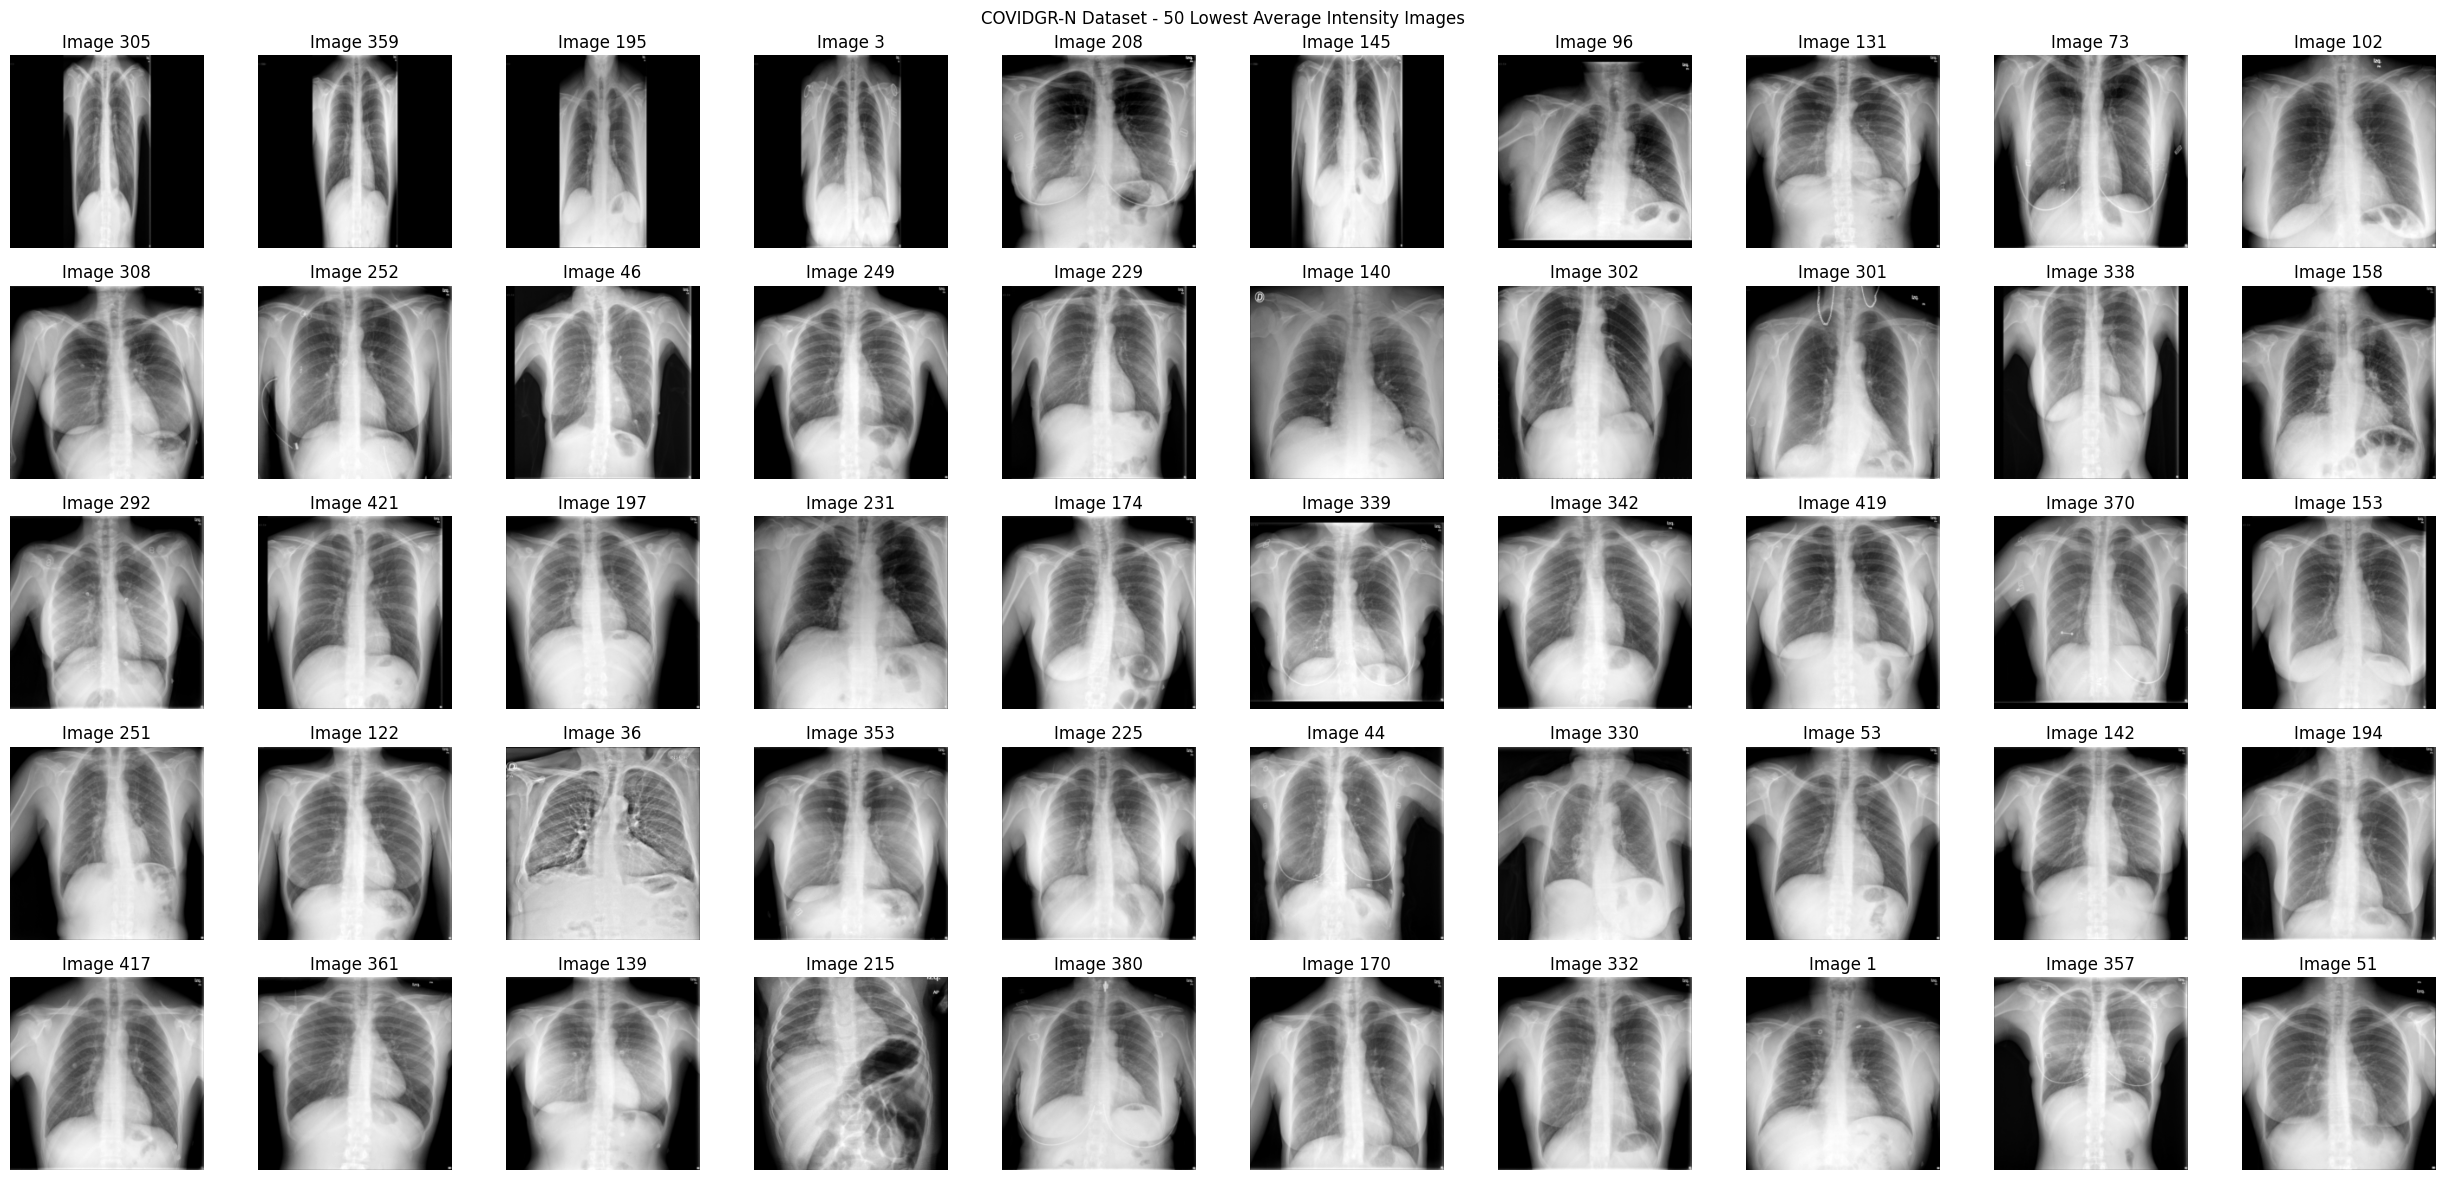

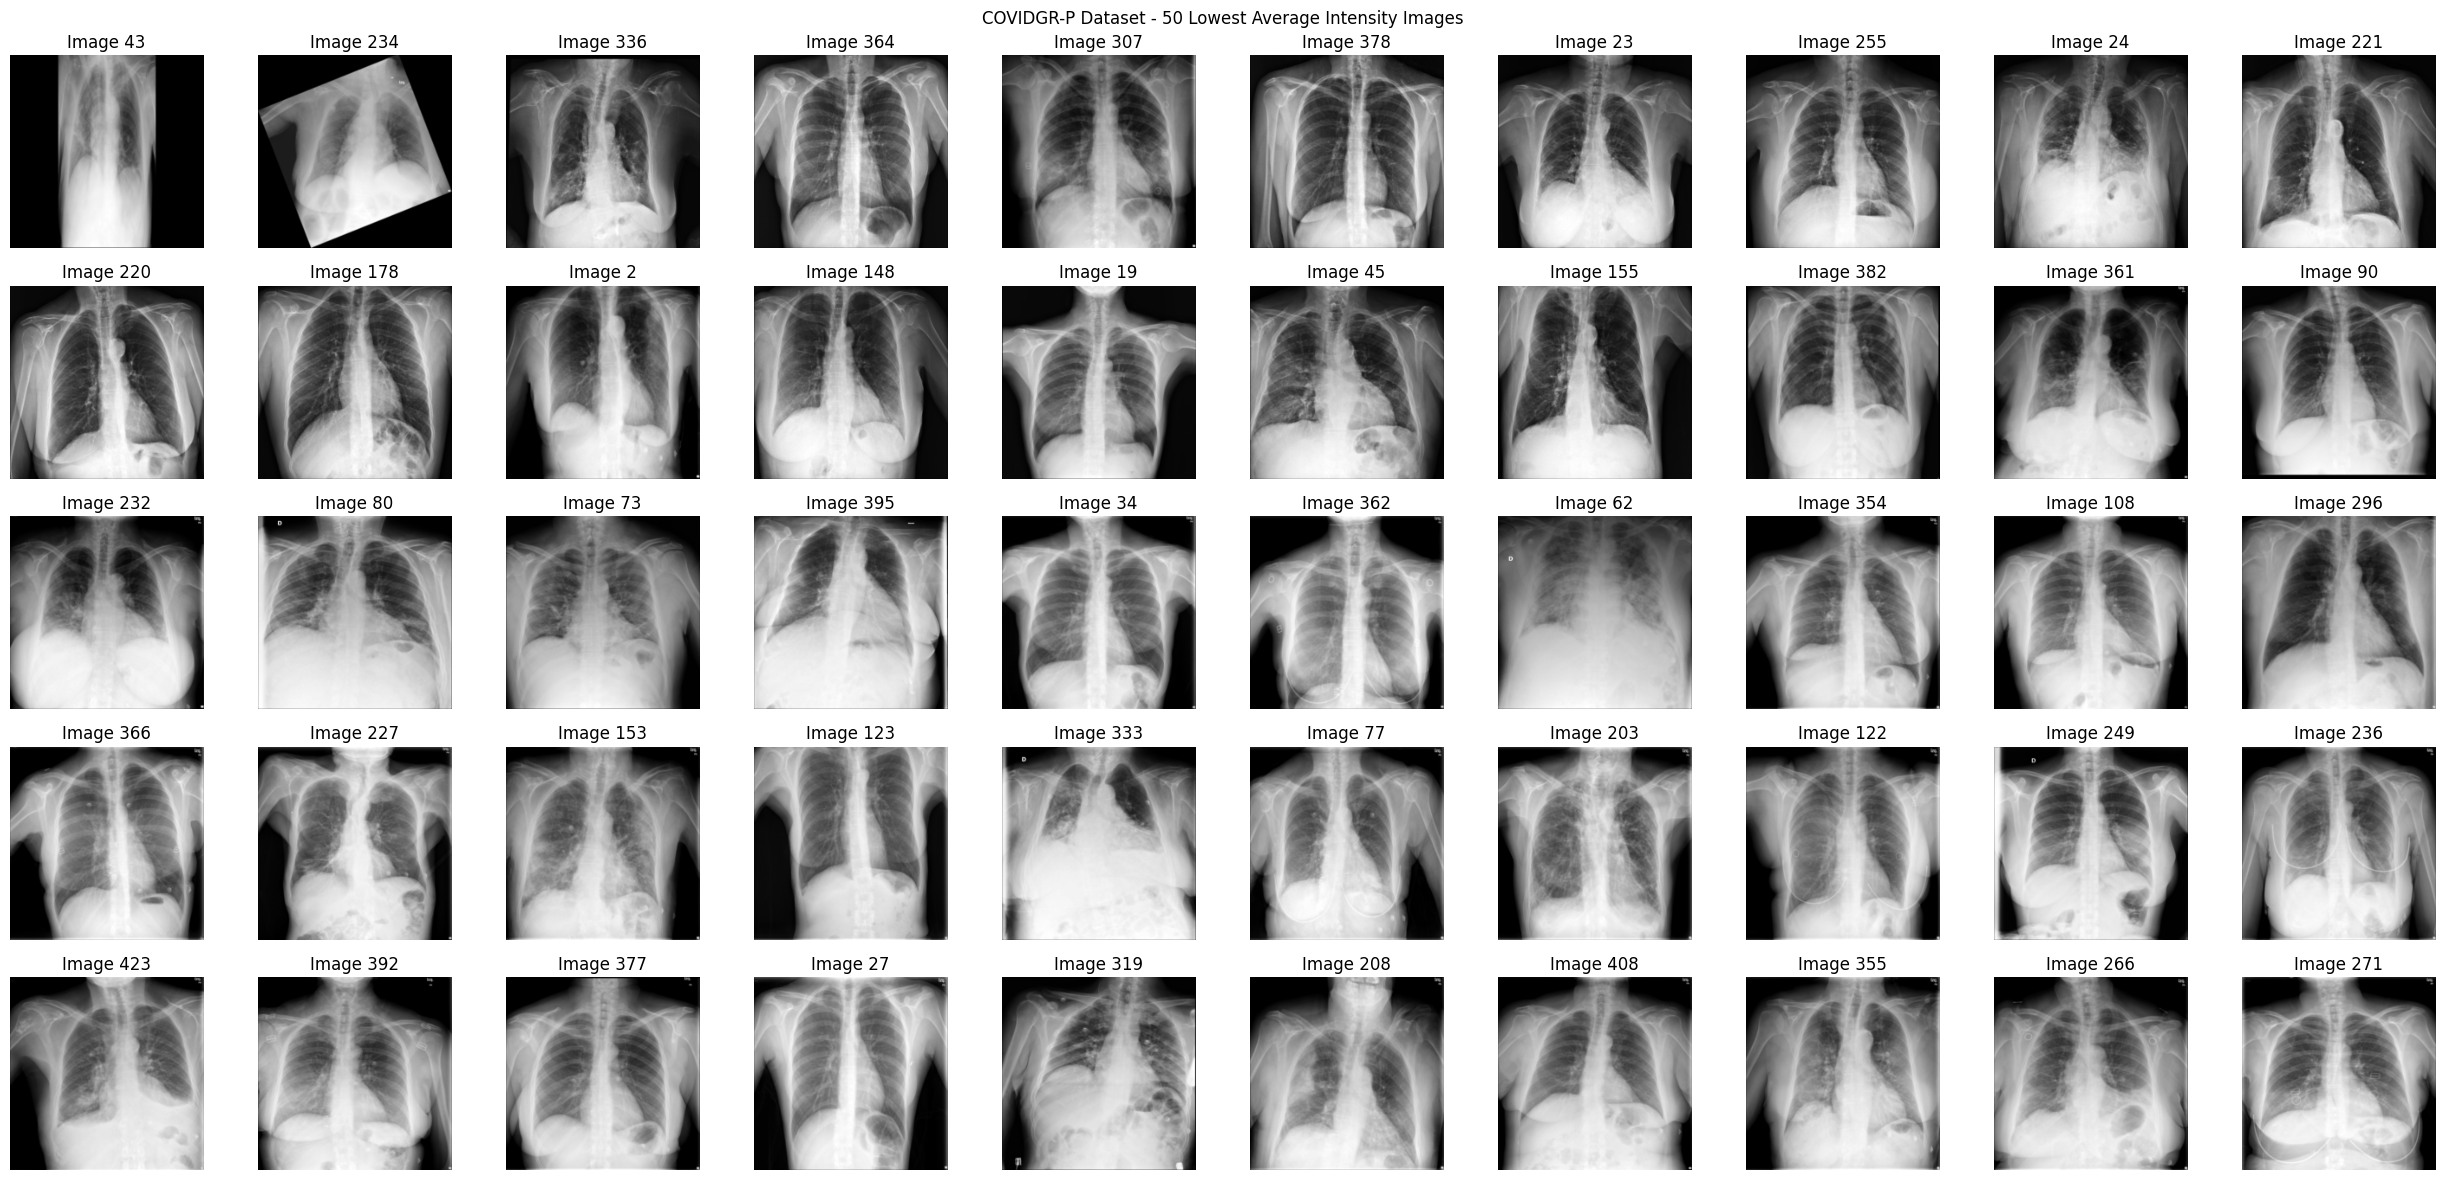

In [29]:
def plot_lowest_intensity_images(image_array, title):
    # Compute the average image intensity
    average_intensity = np.mean(image_array, axis=(1, 2, 3))

    # Sort the images based on their intensity and get the indices of the 50 lowest intensity images
    lowest_intensity_indices = np.argsort(average_intensity)[:50]

    # Plot the 50 lowest intensity images
    plt.figure(figsize=(25, 12))
    for i, idx in enumerate(lowest_intensity_indices):
        plt.subplot(5, 10, i + 1)  # Adjust subplot layout for 50 images
        plt.imshow(image_array[idx].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {idx}')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Call the function for each numpy array
plot_lowest_intensity_images(nihcxr_arrays, "NIHCXR Dataset - 50 Lowest Average Intensity Images")
plot_lowest_intensity_images(brixia_arrays, "Brixia Dataset - 50 Lowest Average Intensity Images")
plot_lowest_intensity_images(covidgr_n_arrays, "COVIDGR-N Dataset - 50 Lowest Average Intensity Images")
plot_lowest_intensity_images(covidgr_p_arrays, "COVIDGR-P Dataset - 50 Lowest Average Intensity Images")

<b>`Figure 2`.</b> Images randomly sampled from each dataset before preprocessing, where image quality issues associate with distribution shift and image distortion can be observed.

Based on visual inspection, we remove:
* The 40 lowest average intensity images from NIHCXR dataset.
* The 38 lowest average intensity images from Brixia dataset.
* The 6 lowest average intensity images from COVIDGR negative dataset.
* The 2 lowest average intensity images from COVIDGR positive dataset.

In [31]:
################################################################################
# PREPROCESSING
################################################################################
# Remove the lowest average intensity images from each dataset

# NIHCXR dataset: Remove the 40 lowest average intensity images
lowest_intensity_indices_nihcxr = np.argsort(np.mean(nihcxr_arrays, axis=(1, 2, 3)))[:40]
nihcxr_np_filtered = np.delete(nihcxr_arrays, lowest_intensity_indices_nihcxr, axis=0)

# Brixia dataset: Remove the 38 lowest average intensity images
lowest_intensity_indices_brixia = np.argsort(np.mean(brixia_arrays, axis=(1, 2, 3)))[:38]
brixia_np_filtered = np.delete(brixia_arrays, lowest_intensity_indices_brixia, axis=0)

# COVIDGR negative dataset: Remove the 6 lowest average intensity images
lowest_intensity_indices_covidgr_n = np.argsort(np.mean(covidgr_n_arrays, axis=(1, 2, 3)))[:6]
covidgr_n_np_filtered = np.delete(covidgr_n_arrays, lowest_intensity_indices_covidgr_n, axis=0)

# COVIDGR positive dataset: Remove the 2 lowest average intensity images
lowest_intensity_indices_covidgr_p = np.argsort(np.mean(covidgr_p_arrays, axis=(1, 2, 3)))[:2]
covidgr_p_np_filtered = np.delete(covidgr_p_arrays, lowest_intensity_indices_covidgr_p, axis=0)

In [32]:
def preprocess_image(image_list, img_size=224):
    df_np = np.empty((len(image_list), img_size, img_size, 1), dtype=np.float32)

    for i, img_array in enumerate(image_list):
        try:
            # Normalize intensity to range (0,1)
            img_preprocessed = skimage.exposure.rescale_intensity(img_array, in_range='image', out_range=(0, 1))

            # Equalize histogram
            img_preprocessed = skimage.exposure.equalize_hist(img_preprocessed)

            # Add Gaussian blur for denoising
            img_preprocessed = gaussian_filter(img_preprocessed, sigma=1)
            
            # Fill the empty numpy array with preprocessed image
            df_np[i] = img_preprocessed
        except:
            continue
    
    return df_np

In [33]:
# Preprocess images and save
brixia_np = preprocess_image(brixia_np_filtered)
np.save("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/Brixia_preprocessed", brixia_np, allow_pickle=False, fix_imports=False)

nihcxr_np = preprocess_image(nihcxr_np_filtered)
np.save("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/NIHCXR_preprocessed", nihcxr_np, allow_pickle=False, fix_imports=False)

covidgr_n_np = preprocess_image(covidgr_n_np_filtered)
np.save("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/COVIDGR_N_preprocessed", covidgr_n_np, allow_pickle=False, fix_imports=False)

covidgr_p_np = preprocess_image(covidgr_p_np_filtered)
np.save("/Users/kay/Documents/GitHub/COVID-detection-from-XRay/Data/COVIDGR_P_preprocessed", covidgr_p_np, allow_pickle=False, fix_imports=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [35]:
################################################################################
# Data Exploration AFTER PREPROCESSING
################################################################################
print("NUMBER OF SAMPLES")
print("Brixia - positive train: ", brixia_np.shape[0])
print("NIHCXR - negative train: ", nihcxr_np.shape[0])
print("COVIDGR - positive test: ", covidgr_p_np.shape[0])
print("COVIDGR - negative test: ", covidgr_n_np.shape[0])

print("\nIMAGE SIZE (HEIGHT, WIDTH, CHANNELS)")
print(covidgr_p_np.shape[1:])

print("\nIMAGE DATA TYPE")
print(covidgr_p_np.dtype)

NUMBER OF SAMPLES
Brixia - positive train:  4657
NIHCXR - negative train:  5959
COVIDGR - positive test:  424
COVIDGR - negative test:  420

IMAGE SIZE (HEIGHT, WIDTH, CHANNELS)
(224, 224, 1)

IMAGE DATA TYPE
float32


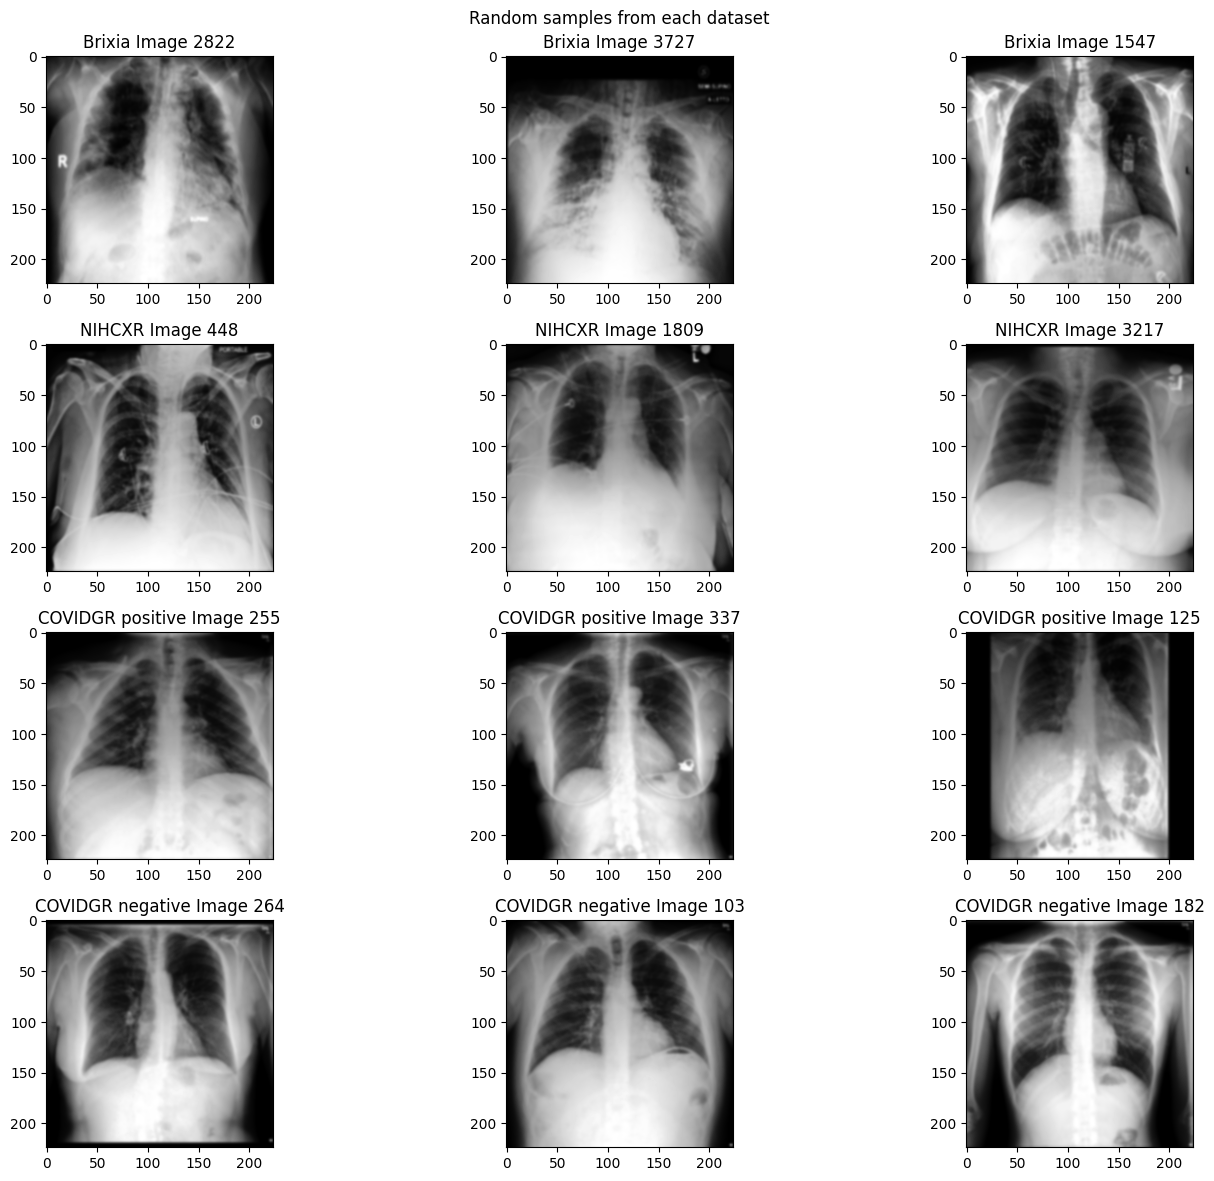

In [96]:
# Create subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 12))

# Plot random samples from each dataset
datasets = [brixia_np, nihcxr_np, covidgr_p_np, covidgr_n_np]
dataset_index = 0
dataset_names = ['Brixia', 'NIHCXR', 'COVIDGR positive', 'COVIDGR negative']

for row in range(4):
    for col in range(3):
        index = np.random.randint(0, len(datasets[dataset_index]))
        axs[row, col].imshow(datasets[dataset_index][index, :, :, 0], cmap='gray')
        axs[row, col].set_title(f'{dataset_names[dataset_index]} Image {index+1}')
    dataset_index += 1

# Adjust layout to prevent overlap
plt.suptitle("Random samples from each dataset")
plt.tight_layout()

# Show the plot
plt.show()

<b>`Figure 3`.</b> Images randomly sampled from each dataset after preprocessing with normalization, histogram euqlization, gaussian blur and filtering based on image intensity.

In [97]:
for dataset, dataset_name in zip(datasets, dataset_names):
    # Calculate descriptive statistics for the current dataset
    avg_intensity = np.mean(np.mean(dataset, axis=(1, 2, 3)))
    max_intensity = np.max(np.mean(dataset, axis=(1, 2, 3)))
    min_intensity = np.min(np.mean(dataset, axis=(1, 2, 3)))
    std_intensity = np.std(np.mean(dataset, axis=(1, 2, 3)))
    std_pixel_values = np.std(dataset)

    # Print descriptive statistics
    print(f"\nDataset: {dataset_name}")
    print("Average image intensity:", avg_intensity)
    print("Maximum image intensity:", max_intensity)
    print("Minimum image intensity:", min_intensity)
    print("Standard deviation of image intensity:", std_intensity)
    print("Standard deviation of pixel values:", std_pixel_values)


Dataset: Brixia
Average image intensity: 0.5046367
Maximum image intensity: 0.5617091
Minimum image intensity: 0.5022249
Standard deviation of image intensity: 0.0031170475
Standard deviation of pixel values: 0.28413525

Dataset: NIHCXR
Average image intensity: 0.5040575
Maximum image intensity: 0.58749944
Minimum image intensity: 0.50205505
Standard deviation of image intensity: 0.0046293274
Standard deviation of pixel values: 0.2853531

Dataset: COVIDGR positive
Average image intensity: 0.50370127
Maximum image intensity: 0.5239587
Minimum image intensity: 0.5021119
Standard deviation of image intensity: 0.0018823713
Standard deviation of pixel values: 0.28634256

Dataset: COVIDGR negative
Average image intensity: 0.5040997
Maximum image intensity: 0.52220315
Minimum image intensity: 0.5022334
Standard deviation of image intensity: 0.0023614569
Standard deviation of pixel values: 0.28515017


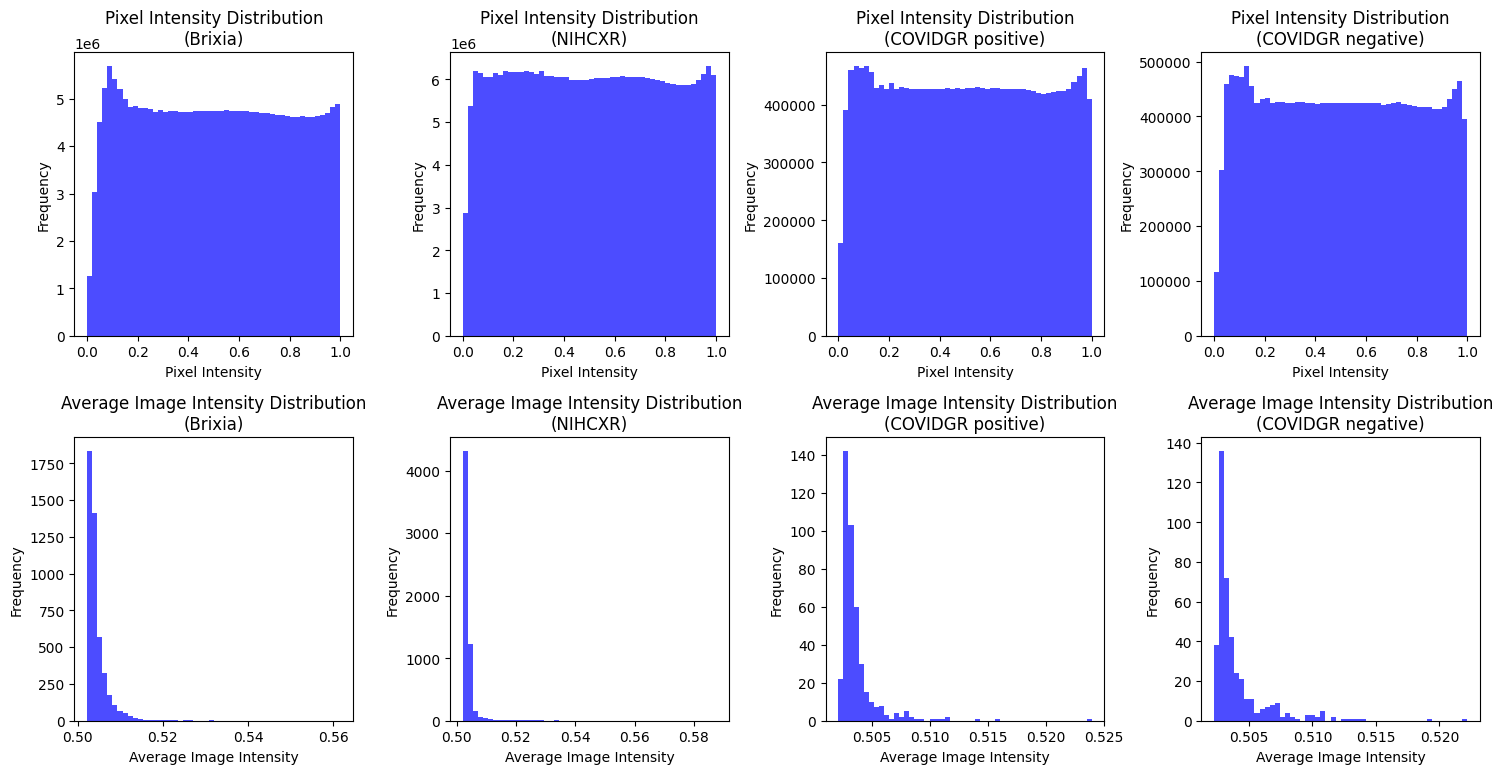

In [98]:
# Define the number of rows and columns for subplots
num_rows = 2
num_cols = len(datasets)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Loop over each dataset
for col, (dataset, dataset_name) in enumerate(zip(datasets, dataset_names)):
    # Flatten the pixel values to compute histogram
    pixel_values = dataset.flatten()

    # Generate histogram for pixel intensity distribution
    axs[0, col].hist(pixel_values, bins=50, color='blue', alpha=0.7)
    axs[0, col].set_title(f'Pixel Intensity Distribution\n({dataset_name})')
    axs[0, col].set_xlabel('Pixel Intensity')
    axs[0, col].set_ylabel('Frequency')

    # Flatten the image values to compute histogram
    image_values = np.mean(dataset, axis=(1,2,3))

    # Generate histogram for average image intensity distribution
    axs[1, col].hist(image_values, bins=50, color='blue', alpha=0.7)
    axs[1, col].set_title(f'Average Image Intensity Distribution\n({dataset_name})')
    axs[1, col].set_xlabel('Average Image Intensity')
    axs[1, col].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<b>`Figure 4`.</b> The pixel and average image intensity for all three datasets, after preprocessing. Compared to Figure 1 (before preprocessing), we observe an improvement in distribution shift.

<a id="modeling"></a>
# 3. Modeling Approach and Process

[Return to table of contents](#table_contents)

<b>items to include per Ed description</b>

~Training details: Time taken, number of epochs, batch size, learning rate etc.

Modeling approach, logical description of modeling decisions and process

Make sure an explanation follows every visualization.

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

<b>someone change this part after the modeling is done </b>

Considering the task at hand, a binary classification of Covid versus non-Covid on chest x-ray images with giant datasets, we decided to use transfer learning. Before the implementation of transfer learning models, we first implemented a naive CNN to see if it is able to learn anything with shallow layers, which if so then we will be able to train more data with limited GPU access. However, the naive CNN proved to be insufficient, thus we moved onto a ResNet50 model as the baseline model. For training the ResNet model, we adopted a gradient of learning rates, starting with a baseline learning rate of 1e-6 for the dense layers while freezing all the pretrained layers, then gradually decreasing the learning rate to 1e-8 and unfreezing a layer at a time to retrain the model. We started with more layers added to the ResNet structure, however we didn't have enough GPU resources to train any epoch of that model. Thus we simplified the model and tested with different hyperparameters. 


For choosing the hyperparameter, we chose the learning rates that exhibited decreasing trend for training/validation loss over epochs, and 1e-5 is the most ideal compared to 1e-4, 1e-6, and 1e-7. We also evaluated the batch size and determined that a batch size of 32 had the lowest training/validation loss, compared to a batch size of 64, 128, and 256. In addition, we evaluated different optimizers and found that Adam had the lowest training/validation loss at a learning rate of 1e-5, compared to RMSprop, SGD, Adagrad, Adadelta, and Adamax. The performance of the model was then evaluated using accuracy, loss, and AUC.  Our initial results by freezing the weights of the transfer model had a validation accuracy of 0.57 and an AUC of 0.616. After re-training the last block (3 additional convolutional + batch normalization layers) with a learning rate of 1e-6, we obtained a validation accuracy of 0.56 and an AUC of 0.528. We attemped to unfreeze the weights of another Resnet Block and re-trained it with a learning rate of 1e-8 (which performed better than lr = 1e-6, 1e-7, and 1e-9). The resulting validation accuracy is 0.57 and the AUC is 0.608. This result deviated from our expectations and our project objectives to achieve a robust model performance to classify COVID-19 cases.


 The strength of our transfer learning model is to prevent spending enormous computational resources on training a large model. Furthermore, our model architecture allows us to unfreeze and re-train additional layers with different hyperparameters if needed. However, our model performance is currently limited on the validation set, although the model was able to learn from the training image shown by a test accuracy of 0.86 after performing train_test_split on the training data. The gap between the training and validation accuracy shows a data quality gap between the training and validation images. Consequently, our next step includes including more image data in the training set, implementing other image preprocessing and dataset alignment techniques, re-training more layers of Resnet50, or try out a different model for transfer learning altogether. 

In [2]:
################################################################################
# LOAD THE PREPROCESSED DATA
################################################################################
##For local loading:
"""
root = str(os.path.dirname(os.path.realpath('milestone_5.ipynb')))
root = root[1:] + '/'

br_path = '/' +os.path.join(root, "Data/Brixia_preprocessed.npy")
brixia_np = np.load(br_path)

nih_path = '/' + os.path.join(root,"Data/NIHCXR_preprocessed.npy")
nihcxr_np = np.load(nih_path)

co_path_1 = '/' + os.path.join(root,"Data/COVIDGR_P_preprocessed.npy")
co_path_2 = '/' + os.path.join(root,"Data/COVIDGR_N_preprocessed.npy")
covidgr_p_np = np.load(co_path_1)
covidgr_n_np = np.load(co_path_2)
"""

##For cloud loading:
brixia_np = np.load("Data/Brixia_preprocessed.npy")
nihcxr_np = np.load("Data/NIHCXR_preprocessed.npy")
covidgr_p_np = np.load("Data/COVIDGR_P_preprocessed.npy")
covidgr_n_np = np.load("Data/COVIDGR_N_preprocessed.npy")

In [3]:
################################################################################
# ORGANIZE THE DATA
################################################################################
#Training and Testing data
X_train = np.vstack((brixia_np, nihcxr_np))
y_train = np.concatenate((np.ones(brixia_np.shape[0]), np.zeros(nihcxr_np.shape[0])))

X_test = np.vstack((covidgr_p_np, covidgr_n_np))
y_test = np.concatenate((np.ones(covidgr_p_np.shape[0]), np.zeros(covidgr_n_np.shape[0])))

#randomly shuffle
shuffled_indices_train = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffled_indices_train, :,:,:]
y_train = y_train[shuffled_indices_train]

shuffled_indices_test = np.random.permutation(X_test.shape[0])
X_test = X_test[shuffled_indices_test, :,:,:]
y_test = y_test[shuffled_indices_test]

In [4]:
################################################################################
# PLOTTING HELPERS
################################################################################
def plot_helper_accuracy(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['accuracy'], label='train')
    ax.plot(model.history.history['val_accuracy'], label='validation')
    best_val = np.argmax(model.history.history['val_accuracy'])
    best_val_value = np.nanmax(model.history.history['val_accuracy'])
    ax.axvline(np.argmax(model.history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_loss(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label=label_train)
    ax.plot(model.history.history['val_loss'], label=label_val)
    best_val = np.argmin(model.history.history['val_loss'])
    best_val_value = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.argmin(model.history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_accuracy_history(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='validation')
    best_val = np.argmax(history.history['val_accuracy'])
    best_val_value = np.nanmax(history.history['val_accuracy'])
    ax.axvline(np.argmax(history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')

def plot_helper_loss_history(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['loss'], label=label_train)
    ax.plot(history.history['val_loss'], label=label_val)
    best_val = np.argmin(history.history['val_loss'])
    best_val_value = np.nanmin(history.history['val_loss'])
    ax.axvline(np.argmin(history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='upper right')

### CNN

In [5]:
################################################################################
# ARCHITECTURE of CNN MODELS
################################################################################
def create_model(input_shape):
    inp = Input(shape=input_shape)
    x = GaussianNoise(stddev=0.1)(inp)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Conv2D(129, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp], outputs=out)
    return model
    
def create_model_updated(input_shape):
    #no batchnorm -- poor performance
    #no learning rate decay -- not necessary
    l2_rate = 0.01
    inp = Input(shape=input_shape)
    x = GaussianNoise(stddev=0.1)(inp)
    x = Conv2D(64, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate), padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = Conv2D(129, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = Conv2D(256, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp], outputs=out)
    return model

def compile_and_train_model(model, optimizer, learning_rate, batch_size, X_train, y_train, epochs):
    es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[es])
    return history

#visualize the architecture of the CNN models
model_cnn_final = create_model((224, 224, 1))
print(model_cnn_final.summary())

2024-05-08 04:18:06.268446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 04:18:06.298517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 04:18:06.301936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 gaussian_noise (GaussianNo  (None, 224, 224, 1)       0         
 ise)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      16448     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0     

L355
2024-05-08 04:18:06.310136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 04:18:06.312941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 04:18:06.516290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

In [6]:
################################################################################
# FINAL CNN MODEL #1 (after all the hyperparmeter tuning)
################################################################################
#note that to make the flow more clear, the intermediate models are not shown here

#runtime counter
start_time = time.time()

#create and train model
input_shape = X_train.shape[1:]
model_cnn_final = create_model(input_shape)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
history = compile_and_train_model(model_cnn_final, 
                                  tf.keras.optimizers.Adam, 
                                  1e-5, 
                                  32, 
                                  X_train, y_train, 
                                  20)
#save model
str_name = 'final_model' + '1e5_32' + '.h5'
model_cnn_final.save(str_name)

#AUC, on the testing set
y_pred = model_cnn_final.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
print('AUC: ', auc) 

#runtime total
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Epoch 1/20


2024-05-08 04:18:11.835415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-08 04:18:12.171636: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-08 04:18:12.550356: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 04:18:13.548181: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 04:18:15.436289: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc140281090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 04:18:15.436324: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capa

266/266 [==============================] - 74s 244ms/step - loss: 0.6552 - accuracy: 0.5972 - val_loss: 0.6170 - val_accuracy: 0.7109
Epoch 2/20
266/266 [==============================] - 63s 237ms/step - loss: 0.5901 - accuracy: 0.6882 - val_loss: 0.5802 - val_accuracy: 0.7500
Epoch 3/20
266/266 [==============================] - 63s 238ms/step - loss: 0.5470 - accuracy: 0.7162 - val_loss: 0.5493 - val_accuracy: 0.7768
Epoch 4/20
266/266 [==============================] - 63s 238ms/step - loss: 0.5022 - accuracy: 0.7471 - val_loss: 0.5175 - val_accuracy: 0.7933
Epoch 5/20
266/266 [==============================] - 63s 238ms/step - loss: 0.4761 - accuracy: 0.7601 - val_loss: 0.4901 - val_accuracy: 0.8060
Epoch 6/20
266/266 [==============================] - 63s 238ms/step - loss: 0.4594 - accuracy: 0.7638 - val_loss: 0.4574 - val_accuracy: 0.8107
Epoch 7/20
266/266 [==============================] - 63s 238ms/step - loss: 0.4440 - accuracy: 0.7823 - val_loss: 0.4644 - val_accuracy: 0.8

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 32ms/step
AUC:  0.6051325247079964
Execution time: 1283.57999253273 seconds


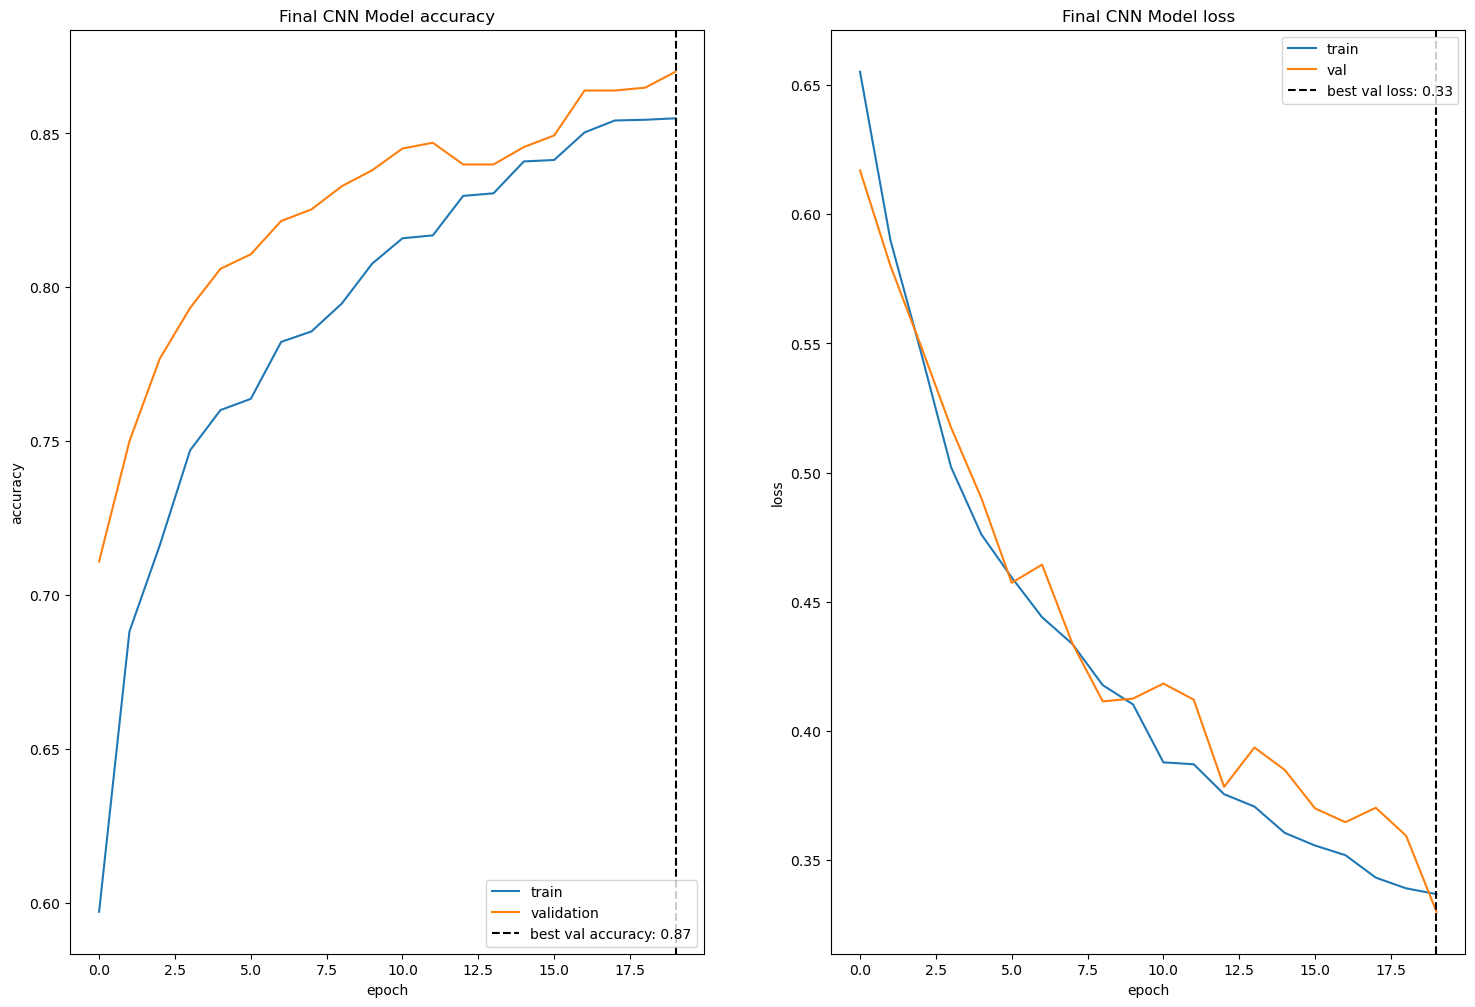

In [7]:
#Plot the results of the first CNN final model
fig, axs = plt.subplots(1, 2, figsize=(18,12))
axs = axs.flatten()

plot_helper_accuracy_history(history, 
                     title=f'Final CNN Model accuracy', 
                     ax=axs[0])
plot_helper_loss_history(history, 
                 title=f'Final CNN Model loss', 
                 ax=axs[1])
plt.show()

<b>`Figure 5`.</b> The first final CNN model after the hyperparameter tuning. It trained for about 21 minutes, 20 epochs, batch size 32, learning rate 1e-5 which were empirically determined from a range of batch sizes (16, 32, 64, 128) and learning rates (from 1e-7 to 1e-2). We observe a reasonably good accuracy on the validation set that was set aside from the training set (0.87), but a non-matching performance on the testing set (0.605). This is perhaps due to the hetergeneous nature of the image scans from different databases, as training and testing sets came from distinct sources. We also observe the problem of overfitting starting around epoch 5, which leads to the second final CNN model to address that problem in order to further improve testing performance.

In [10]:
################################################################################
# FINAL CNN MODEL #2 (after hyperparameter tuning and more regularization)
################################################################################

#runtime counter
start_time = time.time()

#create and train model
model_cnn_final = create_model_updated(input_shape)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
history = compile_and_train_model(model_cnn_final, 
                                  tf.keras.optimizers.Adam, 
                                  1e-5, 
                                  32, 
                                  X_train, y_train, 
                                  10)
#save model
str_name = 'final_model' + '1e5_32' + '.h5'
model_cnn_final.save(str_name)

#AUC, on the testing set
y_pred = model_cnn_final.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
print('AUC: ', auc) 

#runtime total
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Epoch 1/10


2024-05-07 23:03:13.515128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


266/266 [==============================] - 69s 248ms/step - loss: 11.5648 - accuracy: 0.5911 - val_loss: 10.9232 - val_accuracy: 0.6973
Epoch 2/10
266/266 [==============================] - 65s 244ms/step - loss: 10.2934 - accuracy: 0.6955 - val_loss: 9.7429 - val_accuracy: 0.6996
Epoch 3/10
266/266 [==============================] - 65s 245ms/step - loss: 9.2055 - accuracy: 0.7321 - val_loss: 8.7347 - val_accuracy: 0.7363
Epoch 4/10
266/266 [==============================] - 65s 246ms/step - loss: 8.2508 - accuracy: 0.7505 - val_loss: 7.8409 - val_accuracy: 0.7575
Epoch 5/10
266/266 [==============================] - 65s 246ms/step - loss: 7.4013 - accuracy: 0.7659 - val_loss: 7.0358 - val_accuracy: 0.7811
Epoch 6/10
266/266 [==============================] - 65s 246ms/step - loss: 6.6417 - accuracy: 0.7796 - val_loss: 6.3187 - val_accuracy: 0.7669
Epoch 7/10
266/266 [==============================] - 66s 246ms/step - loss: 5.9622 - accuracy: 0.7911 - val_loss: 5.6776 - val_accuracy: 

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 34ms/step
AUC:  0.6124045372866127
Execution time: 662.4768707752228 seconds


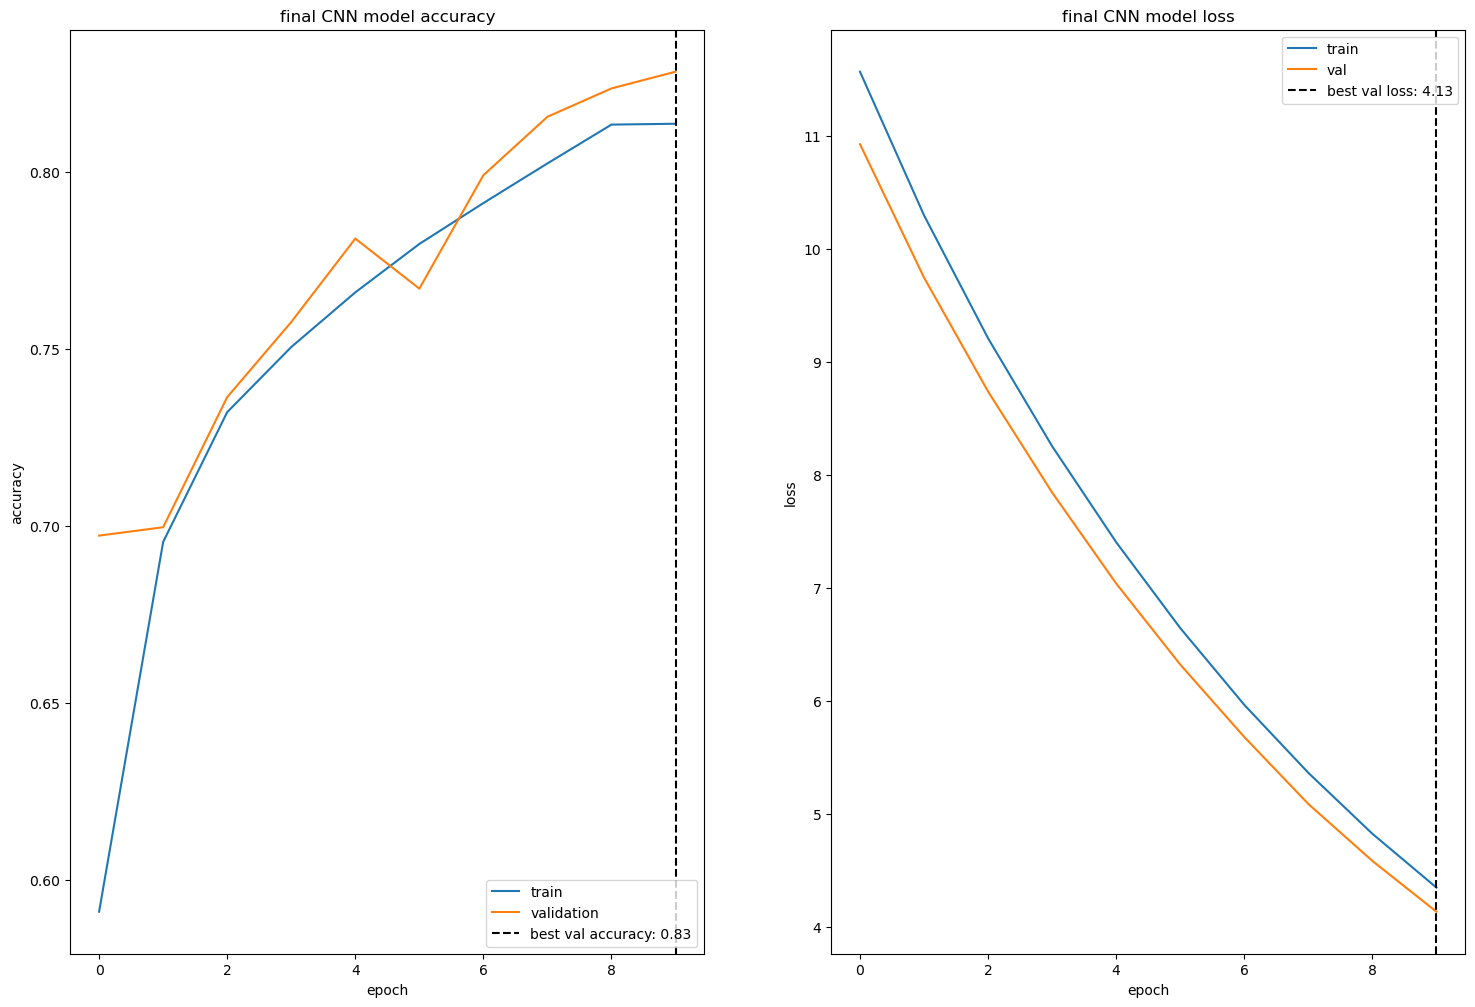

In [11]:
#Plot the results of the second final CNN model
fig, axs = plt.subplots(1, 2, figsize=(18,12))
axs = axs.flatten()

plot_helper_accuracy_history(history, 
                     title=f'final CNN model accuracy', 
                     ax=axs[0])
plot_helper_loss_history(history, 
                 title=f'final CNN model loss', 
                 ax=axs[1])
plt.show()

<b>`Figure 6`.</b> The second final CNN model after more regularization. It trained for about 11 minutes with 10 epochs, and followed the same hyperparameter as the first final CNN model. We observe a reduction in overfitting, but a small performance gap still exists between the training set and the training validation set. The loss curve is smooth and indicates the CNN model was able to learn the patterns of the training set. Based on the first final CNN model in Figure 5 and other testing of epochs, the general trend observed was the better the model learned the training set, the poorer its performance on the testing set, which is understandable based on the image source differences for the training and testing set. Thus, we decided to train for less epochs than the first final CNN model to address it. Compared to the first CNN model (val acc: 0.87), the second CNN model had poorer validation accuracy (val acc:0.83) but did better on the testing set (testing acc: 0.612). In conclusion, the model is limited by the feature and pattern differences across different datasets, even after the preprocessing attempt to smooth out distribution shift and regularization techniques to address overfitting.

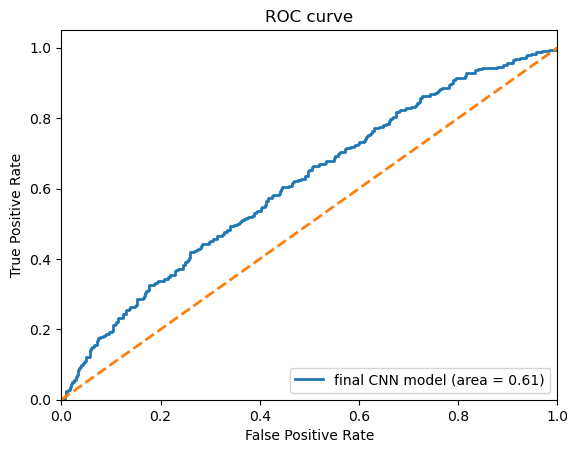

In [18]:
# Plot ROC curve of the second final CNN model
plt.figure()
plt.plot(fpr, tpr, lw=2, label='final CNN model (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

<b>`Figure 7`.</b> This figure shows the ROC curve of the second final CNN model, as described above in `Figure 6` it has a 0.614 accuracy on the testing set.

### Transfer learning - ResNet

In [4]:
################################################################################
# ResNet MODEL (CREATE AND COMPILE)
################################################################################
# Use ResNet50 for transfer learning 
def create_resnet_model(input_shape):
    # Use Imagenet weights
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        # unfreeze the last block of ResNet50
        if layer.name in ['conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_3_conv', 'conv5_block3_3_bn']:
            layer.trainable = True
        else:
            layer.trainable = False
    # Flatten the output of ResNet50 
    x = Flatten()(base_model.output)
    # Dense + Dropout layers 
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Binary classification output
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=out)
    return model

# compile the transfer learning model 
def compile_and_train_resnet_model(model, optimizer, learning_rate, batch_size, X_train, y_train, X_test, y_test, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    # print(model.summary())
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[es])
    return history

In [5]:
#visualize model architecture
create_resnet_model((224,224,3)).summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 30,010,369 (114.48 MB)

 Trainable params: 10,888,321 (41.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

<a id="results_discussion"></a>
# 4. Results and Discussion

[Return to table of contents](#table_contents)

<b>items to include per Ed description</b>


Results: drawing reasonable conclusions & speculations/inferences, addressing strengths, limitations, and future works / Scope of improvement 
